In [ ]:
# Upload your Kaggle API key
from google.colab import files
uploaded = files.upload()  # Upload your kaggle.json file here

Saving kaggle.json to kaggle.json


In [ ]:
# Seting up Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading and extracting FER2013 dataset
!kaggle datasets download -d msambare/fer2013
!unzip -q fer2013.zip

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.60GB/s]


In [ ]:
# Importing libraries
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay

In [ ]:
# Checking the dataset structure
print("Training set:")
for category in os.listdir('/content/train'):
    category_path = os.path.join('/content/train', category)
    if os.path.isdir(category_path):
        num_images = len(os.listdir(category_path))
        print(f"  {category}: {num_images} images")

print("\nTest set:")
for category in os.listdir('/content/test'):
    category_path = os.path.join('/content/test', category)
    if os.path.isdir(category_path):
        num_images = len(os.listdir(category_path))
        print(f"  {category}: {num_images} images")

Training set:
  sad: 4830 images
  disgust: 436 images
  surprise: 3171 images
  neutral: 4965 images
  angry: 3995 images
  fear: 4097 images
  happy: 7215 images

Test set:
  sad: 1247 images
  disgust: 111 images
  surprise: 831 images
  neutral: 1233 images
  angry: 958 images
  fear: 1024 images
  happy: 1774 images


In [ ]:
# Augmenting the disgust class to 4000 images
input_dir = "/content/train/disgust"
output_dir = "/content/train/disgust"

# Loading existing images
images = []
for img_file in os.listdir(input_dir):
    img_path = os.path.join(input_dir, img_file)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (48, 48))
        images.append(img)

images = np.array(images)
current_count = len(images)
target_count = 4000
to_generate = target_count - current_count

print(f"Current: {current_count} images")
print(f"Generating: {to_generate} more images...")

# Createing augmentation generator
augmenter = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

# Generating augmented images
generated = 0
for batch in augmenter.flow(images, batch_size=32, save_to_dir=output_dir,
                            save_prefix='aug', save_format='jpg'):
    generated += len(batch)
    if generated >= to_generate:
        break

print(f": Augmentation complete! Now have ~{target_count} disgust images")

Current: 436 images
Generating: 3564 more images...
: Augmentation complete! Now have ~4000 disgust images


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

print(f"\nClass mapping: {train_generator.class_indices}")

Found 32292 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.

Class mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
from keras.layers import BatchNormalization, Input

model = Sequential([
    Input(shape=(48, 48, 1)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(512, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,728,903 (10.41 MB)

 Trainable params: 2,724,551 (10.39 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

Class weights: {0: np.float64(1.1547291256928303), 1: np.float64(1.1478335051363169), 2: np.float64(1.1259806827295233), 3: np.float64(0.6393822393822394), 4: np.float64(0.9291324989210186), 5: np.float64(0.9551020408163265), 6: np.float64(1.4547911879983781)}


In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

optimizer = Adam(learning_rate=0.001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print(": Model compiled with callbacks")

: Model compiled with callbacks


In [ ]:
import math

steps_per_epoch = math.ceil(train_generator.samples / 64)
validation_steps = math.ceil(test_generator.samples / 64)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=80,
    validation_data=test_generator,
    validation_steps=validation_steps,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stop]
)

print("\n: Training complete!")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
505/505 ━━━━━━━━━━━━━━━━━━━━ 74s 108ms/step - accuracy: 0.1553 - loss: 2.5608 - val_accuracy: 0.1422 - val_loss: 1.9212 - learning_rate: 0.0010
Epoch 2/80
505/505 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.1721 - loss: 2.0255 - val_accuracy: 0.1382 - val_loss: 1.8604 - learning_rate: 0.0010
Epoch 3/80
505/505 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.2397 - loss: 1.8244 - val_accuracy: 0.2621 - val_loss: 1.7818 - learning_rate: 0.0010
Epoch 4/80
505/505 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.3308 - loss: 1.6589 - val_accuracy: 0.4086 - val_loss: 1.5963 - learning_rate: 0.0010
Epoch 5/80
505/505 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.4273 - loss: 1.4849 - val_accuracy: 0.3926 - val_loss: 1.6361 - learning_rate: 0.0010
Epoch 6/80
505/505 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.4985 - loss: 1.3473 - val_accuracy: 0.5174 - val_loss: 1.2701 - learning_rate: 0.0010
Epoch 7/80
505/505 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - accuracy: 0.5318 - 

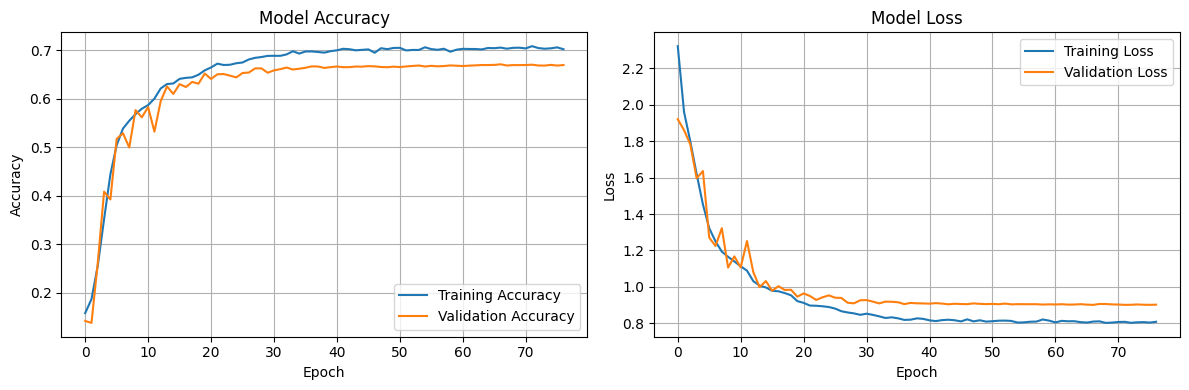

Best validation accuracy: 0.6712
Final validation accuracy: 0.6697


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

In [ ]:
import pickle
from google.colab import files


with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


model.save('emotion_model.keras')

print(": Files saved! Starting downloads...")


files.download('emotion_model.keras')
files.download('training_history.pkl')

print(": Downloads complete!")

: Files saved! Starting downloads...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

: Downloads complete!


In [ ]:
model.save('emotion_model.keras')
print(": Model saved as emotion_model.keras")

: Model saved as emotion_model.keras
